### SENTIMENT ANALYSIS (IN ARABIC) ###

#### TODO ####
  - Test w2v.vocab length to ensure that unknown words are actually being add/trained
  - Remove high sequence # outliers (from 176 to closer to 20/30)
  - Arabic Stop Words (https://github.com/mohataher/arabic-stop-words)
    - https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings/code (https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text)
  - t-SNE implementation (even though it won't make much sense to non-Arabic reader)
  - Grid Search, across Hyperparams
  - GRU vs. LSTM (https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)

In [25]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

__[How is GloVe different from word2vec?](https://www.quora.com/How-is-GloVe-different-from-word2vec)__: TL;DR
 - Perform roughtly the same function, but are built differently (Word2Vec is a "predictive" Feed-Fwd NN w/ SGD)
 - GloVe is result of Stanford NLP wanting to build on the Word2Vec concept of "semantic analogies" and yet retain "intrinsic statistical properties of the corpus" (i.e., "word occurrence statistics")

__[GloVe vs word2vec revisited.](http://dsnotes.com/post/glove-enwiki/)__: TL;DR
 - Results are similar enough (maybe GloVe is slightly more accurate)
 - Trade-off: GloVe uses A LOT of RAM/Memory (on order of 15x more!); Word2Vec is 2x slower

#### Credits ####

 - Sentiment Analysis for Arabic Text (tweets, reviews, and standard Arabic) using word2vec
  - https://github.com/iamaziz/ar-embeddings
  - A. Altowayan and L. Tao "Word Embeddings for Arabic Sentiment Analysis", IEEE BigData 2016 Workshop

In [2]:
from gensim.models import KeyedVectors
def load_w2v():
    return KeyedVectors.load_word2vec_format("/home/zmccoy/sandbox/sentiment-analysis-arabic/arabic-news.bin", binary=True)

In [3]:
w2v = load_w2v()

In [4]:
MAX_SEQUENCE_LENGTH = 176 # based on our inputs; TODO: remove outliers? dynamically calculate!
MAX_NB_WORDS = len(w2v.vocab) #159175 
EMBEDDING_DIM = 300 # w2v 

In [5]:
sample = w2v["حسن"]
print(sample.shape)
print(sample)

(300,)
[-1.6872431   0.06232609  1.0642494  -1.2952522  -0.56399482  1.30242467
  0.25268376 -1.37759209 -2.12782931 -3.13324714 -0.355481    0.49089
 -0.63530803  0.51887447  0.99442923  1.84374964 -1.50754535  1.10023808
  2.31739926  0.24415255  1.60909331  1.56448472  0.58987832  0.53818309
 -0.46916008 -3.7630856  -0.65652722 -1.52495062  2.25925207  3.35305333
  0.66554737 -0.24209391 -2.06305003  3.35495043  0.85857975  1.9354918
 -1.14085197 -1.23579872 -0.14620462  1.02741826  1.00827396  2.12069774
 -1.53577149 -1.30223894  2.6491437   4.66771269 -0.80758655 -1.7406559
 -2.27923775 -4.56534815  0.12741372  2.98800182  0.81155759  1.6151762
 -1.4446131   1.55492806 -2.81950688 -1.56710207 -0.8231591   1.85734284
  1.75780141 -0.51995742  1.27112544  1.08764791 -2.21485662  1.2462399
 -0.17221761 -0.23791917  2.83965659 -0.12337269  0.22964522  0.15169899
 -0.33180708 -0.74332851  1.50870025 -1.16763616 -1.62154007 -0.77913147
 -0.27489448 -0.74075389  1.87118518  2.368469    3

In [6]:
import os
import glob
import codecs
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def get_label(path):
    filename = path[path.rfind('/'):]
    if filename.startswith("/pos"):
        return 1
    return 0

def get_text(path):
    text = ""
    # use codecs.open to ingnore non utf-8 encoded chars; instead of "with open(path, 'r') as myfile:"
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as myfile:
        text = myfile.read()
    return text

def get_text_sequences(texts):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    #print('Found %s unique tokens.' % len(word_index))
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return data, word_index

def get_data_encoded(path):
    vectors = []
    padded_vectors = []
    unknown_words = []
    labels = []
    all_paths = glob.glob(os.path.join(path,'*.txt'))
    np.random.shuffle(all_paths)
    for path in all_paths:
        # use codecs.open to ingnore non utf-8 encoded chars; instead of "with open(path, 'r') as myfile:"
        with codecs.open(path, "r", encoding='utf-8', errors='ignore') as myfile:
            text = myfile.read()
            word_sequences = text_to_word_sequence(text,
                                        filters='ا\n\ufeff\xa0',
                                        #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                        lower=True,
                                        split=" ")
            vector = []
            for word in word_sequences:
                try:
                    vector.append(w2v[word])
                except KeyError:
                    # TODO: incrementally update w2v with OOVs (out-of-vocabularies)
                    #print("' " + str(word) + "' not in vocabulary")
                    unknown_words.append(word)
            vectors.append(vector)
            label = get_label(path)
            labels.append(label)
    padded_vectors = sequence.pad_sequences(vectors, maxlen=MAX_SEQUENCE_LENGTH)
    return np.array(padded_vectors), np.array(labels), unknown_words
    
def get_data(path):
    texts = []
    labels = []
    all_paths = glob.glob(os.path.join(path,'*.txt'))
    np.random.shuffle(all_paths)
    for path in all_paths: 
        texts.append(get_text(path))
        labels.append(get_label(path))
    sequences, word_index = get_text_sequences(texts)
    return sequences, np.array(labels), word_index

In [7]:
X_train, y_train, word_index = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
print(X_train.shape)
print(y_train.shape)
print(len(word_index))
X_valid, y_valid, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
print(X_valid.shape)
print(y_valid.shape)
#X_test, y_test = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/test")
#print(X_test.shape)
#print(y_test.shape)

(1800, 176)
(1800,)
6666
(200, 176)
(200,)


In [8]:
X_train_enc, y_train, unk_train = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
print(X_train_enc.shape)
print(y_train.shape)
print(len(unk_train))
X_valid_enc, y_valid, unk_valid = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
print(X_valid_enc.shape)
print(y_valid.shape)
print(len(unk_valid))

(1800, 176, 300)
(1800,)
4895
(200, 176, 300)
(200,)
1463


In [9]:
def create_embedding_matrix(word_index):
    nb_words = min(MAX_NB_WORDS, len(word_index))+1
    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
    for word, ii in word_index.items():
        if word in w2v.vocab:
            embedding_matrix[ii] = w2v.word_vec(word)
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word_index)
print(embedding_matrix.shape)

(6667, 300)


In [10]:
embedding_layer = w2v.get_keras_embedding(train_embeddings=False)
#embedding_layer.set_weights(embedding_matrix)
#embedding_layer.get_weights()

In [28]:
def get_model_pretrained_embedding(trainable=False):
    weights_filename = "keras-lstm-pretrained-embedding.h5"
    if trainable is True:
        weights_filename = "keras-lstm-pretrained-embedding-trainable.h5"
    #embedding_layer = w2v.get_keras_embedding(train_embeddings=trainable)
    embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable)
    return get_model_embedding(embedding_layer), weights_filename
    
def get_model_from_scratch_embedding():
    embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)
    return get_model_embedding(embedding_layer), "keras-lstm-from-scratch-embedding.h5"
    
def get_model_embedding(embedding_layer):
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
    embeddings = embedding_layer(sentence_indices)   
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    # Returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)
    X = Dense(1)(X)
    X = Activation('sigmoid')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model  

def get_model_no_embedding():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM)))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model, "keras-lstm-no-embedding.h5"

def get_model_pretrained_embedding_bidirectional():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
    embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)
    embeddings = embedding_layer(sentence_indices)   
    X = Bidirectional(LSTM(60, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embeddings)
    X = GlobalMaxPool1D()(X)
    X = Dropout(0.1)(X)
    X = Dense(50)(X)
    X = Activation("relu")(X)
    X = Dropout(0.1)(X)
    X = Dense(1)(X)
    X = Activation('sigmoid')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model, "keras-lstm-pretrained-embedding-bidirectional-trainable.h5"

There are 3 approaches:

 1. Learn embedding from scratch - simply add an Embedding layer to your model
 1. Fine tune learned embeddings - this involves setting word2vec / GloVe vectors as your Embedding layer's weights.
 1. Use word word2vec / Glove word vectors as inputs to your model, instead of one-hot encoding.
 
 
 - (Bidirectional) -see: https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge


In [29]:
#1
model_from_scratch, weights_filepath = get_model_from_scratch_embedding()
#2A
model_pt_frozen, weights_filepath = get_model_pretrained_embedding()
#2B
model_pt_trainable, weights_filepath = get_model_pretrained_embedding(trainable=True)
#3
model_no_embedding, weights_filepath = get_model_no_embedding()
# Bidirectional
model_bidirectional, weights_filepath = get_model_pretrained_embedding_bidirectional()
#model.load_weights(weights_filepath)
#model.summary()

In [32]:
print(weights_filepath)

keras-lstm-pretrained-embedding-bidirectional-trainable.h5


In [30]:
model_from_scratch.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_pt_frozen.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_pt_trainable.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_no_embedding.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_bidirectional.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(filepath=weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
callbacks = [checkpoint, early_stopping]

In [34]:
batch_size = 32
epochs = 10
#model_from_scratch.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks)
#model_pt_frozen.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks)
#model_pt_trainable.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks) 
#model_no_embedding.fit(X_train_enc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_enc, y_valid), callbacks=callbacks)
history = model_bidirectional.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks) 

Train on 1800 samples, validate on 200 samples
Epoch 1/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.3508 - acc: 0.8834
Epoch 00001: val_loss improved from inf to 1.01941, saving model to keras-lstm-pretrained-embedding-bidirectional-trainable.h5
1800/1800 [==============================] - 33s 18ms/step - loss: 0.3503 - acc: 0.8839 - val_loss: 1.0194 - val_acc: 0.5350
Epoch 2/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.1975 - acc: 0.9414
Epoch 00002: val_loss did not improve
1800/1800 [==============================] - 32s 18ms/step - loss: 0.1976 - acc: 0.9411 - val_loss: 1.2697 - val_acc: 0.5400
Epoch 3/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.1010 - acc: 0.9727
Epoch 00003: val_loss did not improve
1800/1800 [==============================] - 34s 19ms/step - loss: 0.1019 - acc: 0.9722 - val_loss: 1.4118 - val_acc: 0.5150
Epoch 4/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9788
Epo

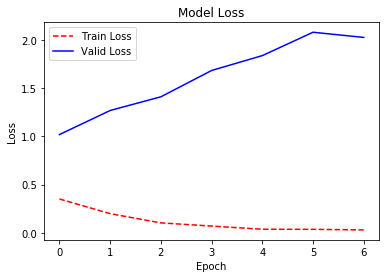

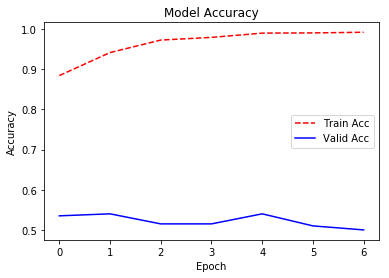

In [35]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [36]:
print("--- FROM SCRATCH EMBEDDINGS ---")
loss, acc = model_from_scratch.evaluate(X_valid, y_valid, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - FROZEN ---")
loss, acc = model_pt_frozen.evaluate(X_valid, y_valid, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_pt_trainable.evaluate(X_valid, y_valid, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- NO EMBEDDING ---")
loss, acc = model_no_embedding.evaluate(X_valid_enc, y_valid, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_bidirectional.evaluate(X_valid, y_valid, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))

--- FROM SCRATCH EMBEDDINGS ---
200/200 [==============================] - 2s 9ms/step
loss / accuracy = 0.6935 / 0.4750
--- ARABIC EMBEDDINGS - FROZEN ---
200/200 [==============================] - 2s 8ms/step
loss / accuracy = 0.6951 / 0.5250
--- ARABIC EMBEDDINGS - TRAINABLE ---
200/200 [==============================] - 2s 8ms/step
loss / accuracy = 0.6911 / 0.5100
--- NO EMBEDDING ---
200/200 [==============================] - 2s 9ms/step
loss / accuracy = 0.6975 / 0.5150
--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---
200/200 [==============================] - 1s 4ms/step
loss / accuracy = 2.0289 / 0.5000


In [37]:
X_erik, y_erik, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik")
print(X_erik.shape)
print(y_erik.shape)

(46, 176)
(46,)


In [38]:
X_erik_enc, y_erik, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik")
print(X_erik_enc.shape)
print(y_erik.shape)

(46, 176, 300)
(46,)


In [39]:
print("--- FROM SCRATCH EMBEDDINGS ---")
loss, acc = model_from_scratch.evaluate(X_erik, y_erik, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - FROZEN ---")
loss, acc = model_pt_frozen.evaluate(X_erik, y_erik, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_pt_trainable.evaluate(X_erik, y_erik, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- NO EMBEDDING ---")
loss, acc = model_no_embedding.evaluate(X_erik_enc, y_erik, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_bidirectional.evaluate(X_erik, y_erik, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))

--- FROM SCRATCH EMBEDDINGS ---
46/46 [==============================] - 0s 9ms/step
loss / accuracy = 0.6915 / 0.6087
--- ARABIC EMBEDDINGS - FROZEN ---
46/46 [==============================] - 0s 7ms/step
loss / accuracy = 0.6589 / 0.7391
--- ARABIC EMBEDDINGS - TRAINABLE ---
46/46 [==============================] - 0s 7ms/step
loss / accuracy = 0.6900 / 0.5870
--- NO EMBEDDING ---
46/46 [==============================] - 0s 8ms/step
loss / accuracy = 0.7153 / 0.3478
--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---
46/46 [==============================] - 0s 5ms/step
loss / accuracy = 2.1209 / 0.4565


In [63]:
prediction = model.predict(np.expand_dims(X_valid[0], axis=0))
print(prediction)
print(y_valid[0])

[[ 0.27497286]]
1


In [95]:
for ii in range(len(X_erik)):
    prediction = model_pt_trainable.predict(np.expand_dims(X_erik[ii], axis=0))
    print(prediction)
    print(y_valid[ii])

[[ 0.81656635]]
1
[[ 0.99748188]]
0
[[  1.80920106e-05]]
0
[[ 0.99516833]]
1
[[ 0.99845576]]
0
[[ 0.00012938]]
1
[[ 0.99482805]]
1
[[ 0.83433056]]
0
[[ 0.96691805]]
0
[[ 0.99261498]]
0
[[ 0.99879694]]
1
[[ 0.89137501]]
1
[[ 0.77385813]]
1
[[ 0.99879694]]
1
[[ 0.65688211]]
0
[[ 0.89137501]]
0
[[ 0.99907851]]
0
[[  7.99180270e-05]]
0
[[  6.49700232e-05]]
1
[[ 0.83953166]]
1
[[ 0.00027996]]
1
[[  4.42184064e-05]]
0
[[ 0.99482805]]
1
[[ 0.95023125]]
0
[[ 0.00012473]]
0
[[ 0.00012175]]
1
[[ 0.99516833]]
1
[[ 0.01390911]]
1
[[ 0.98537529]]
0
[[ 0.00011178]]
0
[[ 0.00475288]]
0
[[  4.42184064e-05]]
0
[[ 0.0011296]]
1
[[ 0.00022305]]
0
[[ 0.00776734]]
0
[[ 0.96172303]]
0
[[ 0.00012938]]
0
[[ 0.00035826]]
1
[[ 0.00022305]]
0
[[ 0.00027996]]
0
[[ 0.01497073]]
0
[[ 0.00012175]]
0
[[ 0.04223976]]
1
[[ 0.99942207]]
1
[[ 0.00053039]]
1
[[ 0.04654312]]
1
